# Spectral Theory
---
**Name:** Jonh Alexis Buot <br>
**Date:** December 2023 <br>
**Course:** CS3101N <br>
**Task:** Assignment - Spectral Theory

---

# Assignment 1

Perform `Spectral Clustering` on any given dataset, and derive conclusions from the results.

In [6]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_kernels
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##  Introduction

Malware analysis plays a pivotal role in enhancing cybersecurity. It serves as a defense mechanism in identifying new and emerging threats, allowing for the development, implementation, and execution of effective detection and preventive strategies. In terms of security incidents, insights gained from malware analysis are crucial for understanding the scope and impact of an attack, enabling security teams to mount timely and effective responses. Malware analysis is then crucial for cybersecurity professionals as it keeps them stay abreast of evolving threats and vulnerabilities.


### Clustering Programs (and Malware) with API calls

Application Programming Interface (API) call sequences are fundamental in every program, as they allow programs to access external services in order to perform a certain task (e.g., calling `malloc` to reserve a memory region). API call sequences are also essential in comprehending the bahavior of malware, as malware utilize API calls to perform malicious behavior on the host computer. This means that given a set of call sequences, we could potentially cluster malware and goodware based on their call sequences.

### Dataset

The dataset used was retrieved from [Kaggle](https://www.kaggle.com/) named [Malware Analysis Datasets: API Call Sequences](https://www.kaggle.com/datasets/ang3loliveira/malware-analysis-datasets-api-call-sequences). It contains `42,797 malware API call sequences` and `1,079 goodware API call sequences`. Each API call sequence is composed of the first 100 non-repeated consecutive API calls associated with the parent process, extracted from the 'calls' elements of Cuckoo Sandbox reports.

**Column Descriptions**

| Column name | Description                          | Type                   |
|-------------|--------------------------------------|------------------------|
| hash        | MD5 hash of the example              | 32 bytes string        |
| t_0 ... t_99| API call                             | Integer (0-306)        |
| malware     | Class                                | Integer: 0 (Goodware) or 1 (Malware) |

### Limitations

Only a portion of the complete dataset (non-duplicate, and non-null containing rows removed) are utilized. This is because of hardware limitations, since utilizing the entire dataset takes too long on my machine. The resulting data would then be composed of 20% of the original dataset's `malware` labeled rows only, and these rows are picked randomly.

### Goal

Perform `Spectral Clustering` to uncover inherent structures within the malware dataset based on API call sequences.

In [7]:
data = pd.read_csv("./Spectral_Theory_Data/dynamic_api_call_sequence_per_malware_100_0_306.csv")
data.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


In [8]:
complete_data = data.dropna()
deduped_data = data.drop_duplicates()

# Randomly sample dataset to use only 20% of the dataset
malware_data = deduped_data[deduped_data["malware"] == 1]
sampled_data = malware_data.sample(frac=0.2)

malware_features = sampled_data.iloc[:, 1:101]
malware_features.head()

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
13622,159,208,260,141,65,208,20,34,215,260,...,208,262,187,135,171,262,208,262,187,262
4819,82,240,117,240,117,240,117,240,117,172,...,141,260,141,224,82,260,141,260,141,260
40152,286,110,172,240,117,240,117,240,117,106,...,260,141,65,86,99,71,215,240,117,240
18816,112,274,158,215,274,158,215,298,76,208,...,117,71,297,135,171,215,35,208,56,71
15470,215,274,158,215,274,158,215,172,117,172,...,81,60,81,60,81,172,117,25,172,117


In [9]:
pipe = Pipeline([("scaler", MaxAbsScaler()), ("pca", PCA(n_components = 2))])
processed_features = pipe.fit_transform(malware_features)

affinity_matrix = pairwise_kernels(processed_features, metric="laplacian", n_jobs=-1)

# Compute Spectral Clustering on various cluster sizes
# Tried using ThreadPoolExecutor to parallelize computations, no effect
clustering_results = []
for n_clusters in range(2, 8):
    sc_model = SpectralClustering(n_clusters=n_clusters, n_jobs=-1, affinity="precomputed", eigen_solver="arpack")
    cluster_labels = sc_model.fit_predict(affinity_matrix)

    silhouette_avg = silhouette_score(processed_features, cluster_labels) 
    clustering_results.append([n_clusters, silhouette_avg, cluster_labels])

# Get the cluster with the highest silhouette score
best_cluster = max(clustering_results, key=lambda res : res[1]) 
sampled_data["cluster"] = best_cluster[2]

scores = pd.DataFrame([res[:-1] for res in clustering_results], columns=["Clusters", "Silhouette Scores"])
scores.head()

,Clusters,Silhouette Scores
0,2,0.519547
1,3,0.623168
2,4,0.469102
3,5,0.498927
4,6,0.518786


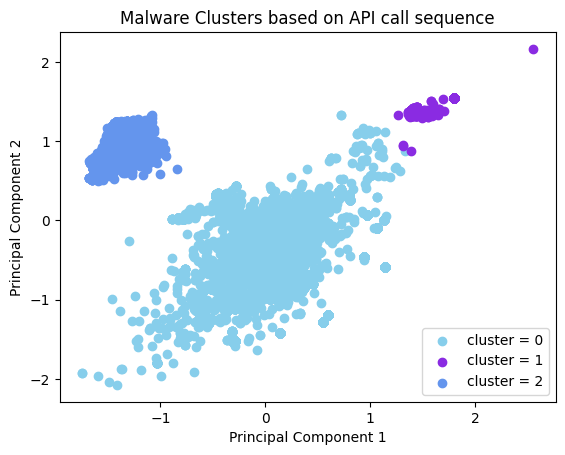

In [41]:
pca_sampled_data = sampled_data[["hash", "cluster"]].copy()

for i in range(processed_features.shape[1]):
    pca_sampled_data[f"PC{i+1}"] = processed_features[:, i]

colorlist =["skyblue", "blueviolet", "cornflowerblue"]
for cluster in range(pca_sampled_data["cluster"].max() + 1):
    cluster_data = pca_sampled_data[pca_sampled_data["cluster"] == cluster]
    plt.scatter(cluster_data["PC1"], cluster_data["PC2"], c = colorlist[cluster], label=f"cluster = {cluster}")

plt.title("Malware Clusters based on API call sequence")
plt.legend(loc="lower right")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Conclusion

In my analysis of the malware dataset using spectral clustering, it was observed that the API call sequences naturally segregate into three distinct clusters. The choice of three clusters maximizes the silhouette score, indicating meaningful separation between the identified groups. This finding suggests that the malware samples exhibit inherent structure, possibly representing different types or families of malware with distinct API call sequences. The use of spectral clustering provides a valuable means of uncovering these underlying patterns in the dataset. To further uncover relationships between the malwares, it is suggested that further analysis is done on the clustered groups with regards to the APIs being called, as well as the sequence that these APIs are called for each malware entry.

# Eigenvector Centrality Assignment

Given the graph below, find its eigenvector centrality.

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

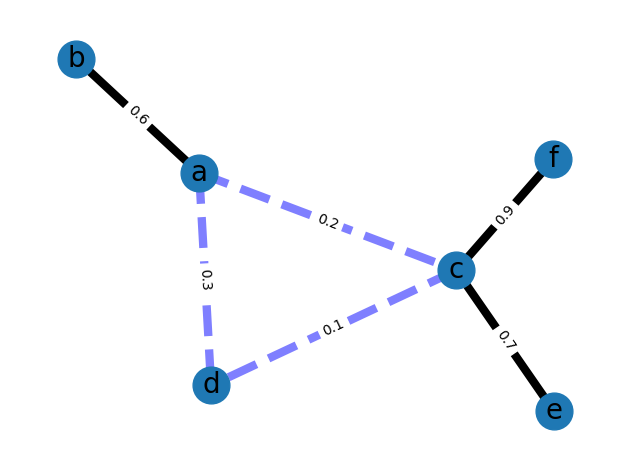

In [12]:
G = nx.Graph()

G.add_edge("a", "b", weight=0.6)
G.add_edge("a", "c", weight=0.2)
G.add_edge("c", "d", weight=0.1)
G.add_edge("c", "e", weight=0.7)
G.add_edge("c", "f", weight=0.9)
G.add_edge("a", "d", weight=0.3)

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed")

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

**Eigenvector Centrality Solution**

In [13]:
nx.eigenvector_centrality(G)

{'a': 0.51807347662071,
 'b': 0.21182192277183212,
 'c': 0.5986761070959697,
 'd': 0.4566010978754134,
 'e': 0.24477918831750853,
 'f': 0.24477918831750853}

# Assignment 2

Think about an interesting topic that you can find in Reddit (Not COVID-19). On your chosen topic develop a hypothesis, and conduct a social network analysis. Find the eigenvector centrality of the social network, and determine which nodes are central in terms of eigenvectors. Lastly, develop a conclusion from your hypothesis.

In [63]:
from itertools import chain
import praw
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

The gaming community has and unprecedented excitement and anticipation surrounding the release of highly anticipated titles, often shaping a virtual ecosystem of discussions and speculations. One of those highly anticipated game is ["Grand Theft Auto VI" (GTA VI)](https://en.wikipedia.org/wiki/Grand_Theft_Auto_VI). Its [trailer](https://www.youtube.com/watch?v=QdBZY2fkU-0&ab_channel=RockstarGames) which was release on December 05, 2023 had garnered 144M views to date. 

Reddit, being a dynamic and diverse social platform, serves as a vibrant space for gamers to converge, share opinions, and speculate on the much-anticipated release. With this, I wanted to conduct a social network analysis on the hype garnered by GTA VI, and Reddit is one of the best places to do this due to its diverse user base providing a comprehensive perspective, upvote/downvote structure, and it being a free-speech aimed platform.

### Hypothesis

Users who receive massive upvotes, actively contribute, and engage in discussions within the GTA VI community are more influential. I believe that their centrality in the social network, indicating a central position, reflects a certain level of influence or authority within the GTA VI community. 

### Methods

To test this hypothesis, a social network analysis will be conducted on the interactions within the GTA communities on Reddit, specifically [GTA](https://www.reddit.com/r/GTA/), and [GTA VI](https://www.reddit.com/r/GTA6/). By constructing a graph where nodes represent users and edges represent interactions (comments, discussions, upvotes), the eigenvector centrality will be calculated for each user. Eigenvector centrality serves as a measure of a user's influence within the network, considering both the quantity and quality of their connections.

## Analysis and Discussion

### Scraping Reddit and Building the Social Network

In [124]:
gta_network = nx.Graph()

reddit = praw.Reddit(
    client_id = "u01nV9XriM4AM36RNQ25DA",
    client_secret = "5sVtNjbuCKG3_Ljl81gDYiiO4EwX1w",
    user_agent = "Big_Feed3369",
)

comment_count = 20
gta_sub = reddit.subreddit("GTA")
gta_vi_sub = reddit.subreddit("GTA6")

gta_vi_search_results_in_gta_sub = gta_sub.search(query="GTA VI", sort="top", time_filter="all", limit=10)
gta_vi_hot_posts = gta_vi_sub.top(limit=10)

for result_id in chain(gta_vi_search_results_in_gta_sub, gta_vi_hot_posts):
    post = reddit.submission(id=result_id)
    post.comment_limit = comment_count

    if post.author is not None: 
        if post.author not in gta_network.nodes:
            gta_network.add_node(post.author, posts=0, posts_karma=0, comments=0, comments_karma=0, posters_interacted=set())

        gta_network.nodes[post.author]["posts"] += 1
        gta_network.nodes[post.author]["posts_karma"] += post.score

    comments = [(post.author, c) for c in post.comments.list()]
    for op, comment in comments:
        if isinstance(comment, praw.models.MoreComments):
            continue
        
        if comment.author is not None:
            if comment.author not in gta_network.nodes:
                gta_network.add_node(comment.author, posts=0, posts_karma=0, comments=0, comments_karma=0, posters_interacted=set())
            
            if op is not None and comment.author != op:
                gta_network.add_edge(comment.author, op)
            
            if post.author != comment.author:
                gta_network.nodes[comment.author]["posters_interacted"].add(post.author)
            
            gta_network.nodes[comment.author]["comments"] += 1
            gta_network.nodes[comment.author]["comments_karma"] += comment.score
            
        comments.extend([(comment.author, r) for r in comment.replies.list()])

print(f"{'Basic Information':<20}:", gta_network)
print(f"{'Average Degree':<20}:", sum(deg for _, deg in gta_network.degree) / len(gta_network.degree))
print(f"{'Graph Density':<20}:", nx.density(gta_network))
print(f"{'Global Coefficient':<20}:", nx.transitivity(gta_network))

Basic Information   : Graph with 373 nodes and 643 edges
Average Degree      : 3.447721179624665
Graph Density       : 0.009268067687163078
Global Coefficient  : 0.2935533384497314


A relatively large graph with 373 nodes and 643 edges generated from the scraped data form the top 10 posts on the GTA VI subreddit, the top "GTA VI" search queries in the GRA subreddit, and the top 20 comments for each of the scraped posts. These forms a graph with a density of 0.9927 which suggests that the network is quite sparse, which may be the case due to redditors interacting only on a handful of posts, and not every post that they encounter.

The average degree of 3.45 signifies the average number of connections each node has. In practical terms, this suggests that, on average, each redditor is directly connected to about three or four other redditors in the network. The average degree is a fundamental measure of network connectivity.

The global coefficient of 0.2935 indicates a moderate level of clustering in the network. Clustering measures the tendency of nodes to form groups or clusters. A higher clustering coefficient suggests that nodes in the network are more likely to be connected to each other, forming local clusters or communities.

### Social Network Node Degrees

In [194]:
deg = dict(gta_network.degree)
eig_cn = nx.eigenvector_centrality(gta_network, max_iter=1000)

data = pd.DataFrame([{
   "User": user, 
   "Degree": deg[user],
   "Eigenvector Centrality": eig_cn[user],
   "Poster": gta_network.nodes[user]["posts"] > 0,
   "Posts": gta_network.nodes[user]["posts"], 
   "Post Karma": gta_network.nodes[user]["posts_karma"], 
   "Comments": gta_network.nodes[user]["comments"],
   "Comment Karma": gta_network.nodes[user]["comments_karma"],
   "Posters Interacted": ", ".join(str(poster) for poster in gta_network.nodes[user]["posters_interacted"]),
} for user in eig_cn])

data.sort_values("Degree", ascending=False).head(20)

,User,Degree,Eigenvector Centrality,Poster,Posts,Post Karma,Comments,Comment Karma,Posters Interacted
110,Zxwl,36,1.919072e-11,True,2,2912,0,0,
177,PapaXan,36,9.798856e-11,True,2,88920,3,3408,
312,ResponsibleRatio6569,20,2.768687e-10,True,1,10730,0,0,
353,PikaPikaGamer,20,6.264295e-05,True,1,9467,0,0,
20,J4C3RT1,20,1.718110e-12,True,1,3211,0,0,
146,Veers_Memes,20,3.135662e-13,True,1,1414,0,0,
0,NomadicMeowOfficial,19,5.981199e-13,True,1,5178,2,554,
253,Impossible-Wear-7508,19,3.254118e-04,True,1,17129,0,0,
196,Outlaw_Orthur,19,2.050440e-13,True,1,28519,1,1377,
292,Bradbrad7,19,1.117294e-13,True,1,12579,0,0,


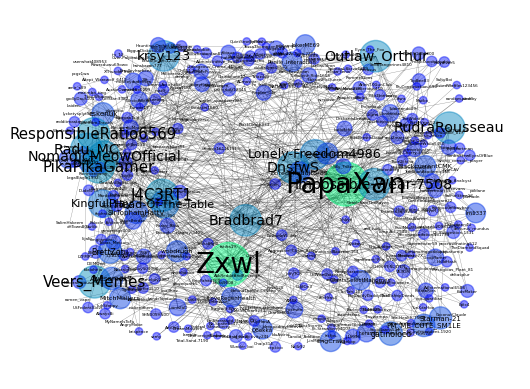

In [204]:
def draw_scaled_graph(graph, scaling_map, scale=1):
    pos = nx.spring_layout(graph, scale=50, iterations=5, k=0.4)
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=max(scaling_map[node] * 20 * scale, 3), ha="center", va="center")

    nx.draw(gta_network, pos, width=0.25, alpha=0.45,
            node_color=list(scaling_map.values()), cmap=plt.cm.winter, 
            node_size=[degs * 1000 * scale for degs in scaling_map.values()])

node_degrees = dict(gta_network.degree)
deg_range = max(node_degrees.values()) - min(node_degrees.values())
node_degrees = { node: (deg - min(node_degrees.values())) / deg_range for node, deg in node_degrees.items() }

draw_scaled_graph(gta_network, node_degrees)

It can be shown in the graph that based on node degrees the graph is dominated by PapaXan and Zxwl, each having a node degree of 36. Referencing the table, most of the users listed are also posters, with an exception of two being commenters of the post made by RudraRousseau, PIkaPIkaGamer, and Impossible-Wear-7508. This implies that being a poster results in a higher node degree. This may be due to redditors being more willing to interact with the actual post itself, rather than comments on the post.

### Eigenvector Centrality

In [212]:
columns = ["User", "Eigenvector Centrality", "Degree", "Posts", "Post Karma", "Comments", "Comment Karma", "Poster"]
data[data["Poster"]][columns].sort_values("Eigenvector Centrality", ascending=False)

,User,Eigenvector Centrality,Degree,Posts,Post Karma,Comments,Comment Karma,Poster
215,RudraRousseau,3.491010e-01,19,1,27244,1,1252,True
253,Impossible-Wear-7508,3.254118e-04,19,1,17129,0,0,True
353,PikaPikaGamer,6.264295e-05,20,1,9467,0,0,True
312,ResponsibleRatio6569,2.768687e-10,20,1,10730,0,0,True
177,PapaXan,9.798856e-11,36,2,88920,3,3408,True
110,Zxwl,1.919072e-11,36,2,2912,0,0,True
20,J4C3RT1,1.718110e-12,20,1,3211,0,0,True
0,NomadicMeowOfficial,5.981199e-13,19,1,5178,2,554,True
61,Lonely-Freedom4986,3.829706e-13,17,1,1952,0,0,True
146,Veers_Memes,3.135662e-13,20,1,1414,0,0,True


Looking into the eigenvector centrality of each posting user to evaluate their influence over the network relative to each other, it can be seen that the eigenvector centrality doesn't completely relate with the node degree, number of posts, post karma, number of comments, nor comment karma. This means that their influence is not only subjected by their own interactions, but is also highly subjected to the influence with possibly the nodes that they are connected to as well.

In [201]:
data.sort_values("Eigenvector Centrality", ascending=False).head(30)

,User,Degree,Eigenvector Centrality,Poster,Posts,Post Karma,Comments,Comment Karma,Posters Interacted
215,RudraRousseau,19,0.349101,True,1,27244,1,1252,
216,gatinoloco,11,0.318983,False,0,0,1,5536,RudraRousseau
228,Awesomex7,10,0.312182,False,0,0,8,3008,RudraRousseau
227,Starman-21,10,0.312182,False,0,0,4,2632,RudraRousseau
222,PM_ME_CUTE_SM1LE,10,0.312182,False,0,0,2,1970,RudraRousseau
234,MitchMaljers,9,0.295847,False,0,0,256,13312,RudraRousseau
233,BlackcurrantCMK,9,0.295847,False,0,0,128,24192,RudraRousseau
232,woodrugh,9,0.295847,False,0,0,64,21760,RudraRousseau
231,EngCraig,9,0.295847,False,0,0,32,11360,RudraRousseau
229,KingAltair2255,9,0.295847,False,0,0,16,4864,RudraRousseau


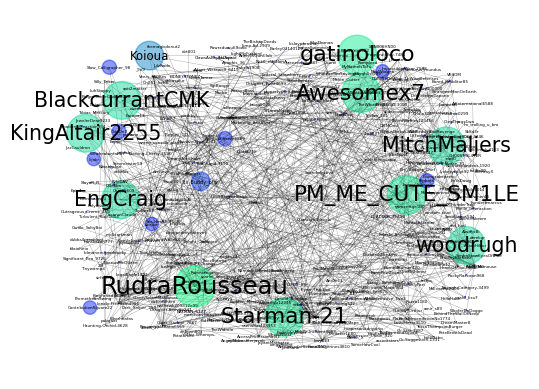

In [208]:
user_eig_cn = dict(zip(data["User"], data["Eigenvector Centrality"]))
draw_scaled_graph(gta_network, user_eig_cn, scale=2.5)

The table shows that the ones that dominate the graph in terms of eigenvalue centrality are sorted by the top ranking posters followed by those that interact under their comments. This table shows that the influence of a node is not merely judged by the user's karma and posts on the subreddit, but also the influence exerted by those that comment on their post. If the ones that comment on their post are influential, which means garnering high karma scores and engagement on their interactions, then the poster also gets a boost on their influentiality over the network. 

In [219]:
locality = (data["User"] == "RudraRousseau") | data["Posters Interacted"].str.contains("RudraRousseau")
data[locality].sort_values("Eigenvector Centrality", ascending=False).head(30)

,User,Degree,Eigenvector Centrality,Poster,Posts,Post Karma,Comments,Comment Karma,Posters Interacted
215,RudraRousseau,19,0.349101,True,1,27244,1,1252,
216,gatinoloco,11,0.318983,False,0,0,1,5536,RudraRousseau
228,Awesomex7,10,0.312182,False,0,0,8,3008,RudraRousseau
222,PM_ME_CUTE_SM1LE,10,0.312182,False,0,0,2,1970,RudraRousseau
227,Starman-21,10,0.312182,False,0,0,4,2632,RudraRousseau
233,BlackcurrantCMK,9,0.295847,False,0,0,128,24192,RudraRousseau
232,woodrugh,9,0.295847,False,0,0,64,21760,RudraRousseau
231,EngCraig,9,0.295847,False,0,0,32,11360,RudraRousseau
229,KingAltair2255,9,0.295847,False,0,0,16,4864,RudraRousseau
234,MitchMaljers,9,0.295847,False,0,0,256,13312,RudraRousseau


However, when looking at the locality of the users that are on one post, it can be seen that the eigenvalue centrality values scales with the degree. For example, in RudraRousseau's post, the poster themself have the highest eigenvalue centrality value, as well as degree, while those that interacted within his post have lower degrees and eigenvalue centrality but are directly proportionate to each other. 

## Conclusion

Based on the findings, it can be said that the influentiality of a user over the Reddit network is based not just on their own interactions (posts and comments), and scores (karma) in the community; it is also highly influenced by the ones interacting with them. This means that a post is far more influencial, if the interactions below it are also highly influential. This is evidenced by comparing PapaXan's and RudraRousseau's post, wherein PapaXan's 2 posts scored them a degree of 36, and a karma score of 88 920, but was merely 5th in terms of influentiality rankings. Meanwhile, Rudrarousseau's single post and single comment raked him a total karma score of 28 496, and a degree of 19 which is lower than PapaXan's 2 posts in all accounts, but Rudrarousseau was considered 1st in terms of influentiality over the network due to the influentiality of those that commented on their post as well.

This means that the hypothesis is not completely accurate. To become an influential user over the community, one must not only have high engagements, active contributions, and massive upvotes but also foster interactions with other influential users. The network dynamics reveal that a user's influence is intricately connected to the interactions within their posts and comments. The case of RudraRousseau highlights that even with fewer posts and a lower degree, the influentiality ranking can surpass users with higher degrees if their interactions involve influential contributors. Therefore, building a network within the community and engaging with other influential users appears to play a crucial role in determining overall influentiality. This suggests a more nuanced understanding of influence within the GTA VI community, emphasizing the importance of collaborative interactions and the ripple effect of engaging with other influential contributors.